# Introduction 

Ce notebook présente une approche pour déterminer les couleurs d'une image initialement en noir et blanc, en utilisant les bibliothèques numpy et ???, puis en explorant en complément un algorithme de Machine Learning.

Ce projet s'intègre dans le cadre du cours I3 Python Scientifique de Centrale Méditerannée. Il a été mené par Thomas Roujou et Mathis Rezaï.

Il suit le plan suivant : 

I. Une première approche à partir de la fonction rgb2gray

II. Une deuxième approche via une régression linéaire

1. Construction du modèle

2. Résultats en fonction des jeux de données

Conclusion


Bonus : approche via réseau de neurones avec la bibliothèque tensorflow

1. Elaboration de réseau de neurones

2. Entrainement du modèle

3. Visualisation


# I. Une première approche à partir de la fonction rgb2gray

Tout d'abord nous devons importer toutes les librairies qui nous seront nécessaires pour cette partie

In [ ]:
import sys
import numpy as np
from skimage import io, color
from skimage.transform import resize
import matplotlib.pyplot as plt

Commençons par télécharger une photographie de mer en couleur. Nous allons la traduire matriciellement avec la fonction io.imread, et la redimensionner pour réduire le volume de données.

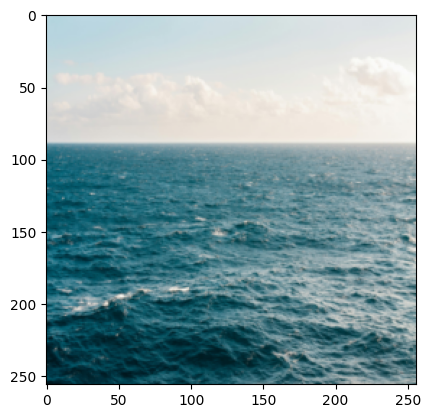

In [21]:
image_path = '../images/mer.jpg'
image_color = io.imread(image_path)
image_color = resize(image_color, (256, 256), anti_aliasing=True)  # Redimensionne à 256x256
image_color = (image_color * 255).astype(np.uint8)  # Reconvertir en entier
plt.imshow(image_color)

La fonction `rgb2gray` de skimage permet de transformer une image en couleur en une image en noir et blanc. La fonction utilise la formule suivant pour calculer la valeur en niveau de gris.


$$l = 0.2125 \cdot R + 0.7154 \cdot G + 0.0721 \cdot B$$


Avec :
- \(R\) : Intensité du canal rouge.
- \(G\) : Intensité du canal vert.
- \(B\) : Intensité du canal bleu.
- \(l\) : Valeur en niveaux de gris (luminance).

Les coefficients utilisés (\(0.2125\), \(0.7154\), \(0.0721\)) sont basés sur la norme **ITU-R BT.709**, qui reflète la perception humaine des couleurs.


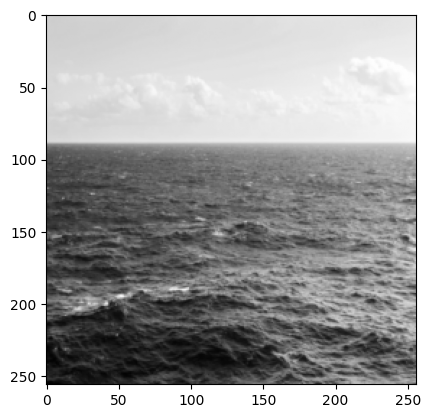

In [24]:
image_gray = color.rgb2gray(image_color)
plt.imshow(image_gray, cmap = 'gray') # cmap = 'gray' force une échelle de gris pour empêcher la colormap viridis (mise par défaut) de mettre des fausses couleurs.

On crée ensuite la fonction inverse : la fonction `gray2rgb`

In [26]:
def gray2rgb(image_gray):
    """
    Convertit une image en niveaux de gris (2D) en une image RGB (3D)
    en utilisant les coefficients de la norme ITU-R BT.709.

    Parameters:
        image_gray (numpy.ndarray): Image en niveaux de gris (2D).

    Returns:
        numpy.ndarray: Image RGB (3D) où chaque pixel contient [R, G, B].
    """
    # Vérification que l'image est bien en niveaux de gris (2D)
    if len(image_gray.shape) != 2:
        raise ValueError("L'image d'entrée doit être en niveaux de gris (2D).")
    
    # Coefficients de pondération de la norme ITU-R BT.709
    coeffs = np.array([0.2125, 0.7154, 0.0721])
    
    # Créer une image RGB en appliquant les coefficients
    image_rgb = np.stack([
        image_gray * coeffs[0],  # Canal rouge
        image_gray * coeffs[1],  # Canal vert
        image_gray * coeffs[2]   # Canal bleu
    ], axis=-1)
    
    return np.clip(image_rgb, 0, 1)  # Normalisation pour rester entre 0 et 1


Maintenant que la fonction est créee, nous pouvons la tester sur notre photogaphie de mer et comparer les images :

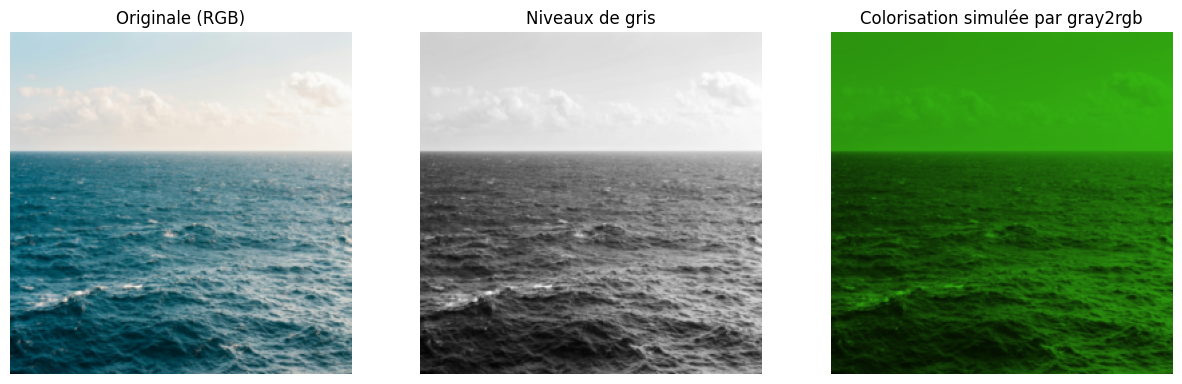

In [29]:
# Appliquer la fonction gray2rgb
image_rgb_simulated = gray2rgb(image_gray)

# Afficher les résultats
plt.figure(figsize=(15, 5))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image_color)
plt.axis('off')
plt.title("Originale (RGB)")

# Image en niveaux de gris
plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.title("Niveaux de gris")

# Image simulée
plt.subplot(1, 3, 3)
plt.imshow(image_rgb_simulated)
plt.axis('off')
plt.title("Colorisation simulée par gray2rgb")

plt.show()


La fonction `gray2rgb` ne peut pas fonctionner correctement pour plusieurs raisons.

Lors de la conversion d'une image RGB (en couleur) en niveaux de gris, les trois canaux de couleur ($R$, $G$, $B$) sont combinés en un seul canal de luminance ($l$) en utilisant la formule suivante :

$$
l = 0.2125 \cdot R + 0.7154 \cdot G + 0.0721 \cdot B
$$

Cette transformation entraîne une perte d'informations. Plusieurs combinaisons de $R$, $G$, $B$ différentes peuvent produire la même valeur de $l$. Par exemple : 
$(R, G, B) = (100, 200, 50)$ et $(R, G, B) = (150, 180, 70)$ peuvent donner exactement le même niveau de gris.

Cette perte rend impossible la reconstruction exacte des couleurs d'origine à partir de l'image en niveaux de gris. En d'autres termes, la fonction `rgb2gray` n'est pas bijective, car elle n'est ni injective (différents $(R, G, B)$ peuvent produire le même $l$) ni surjective (tous les $(R, G, B)$ ne peuvent pas être atteints par une valeur de $l$).

De plus pour que `gray2rgb` fonctionne, l'entrée doit être une image en niveaux de gris (matrice 2D). Si l'entrée est une image en couleur (matrice 3D), la fonction échouera ou produira des résultats incohérents. Même si l'entrée est correcte (une image en niveaux de gris), la fonction attribue des couleurs de manière arbitraire (selon des coefficients prédéfinis) et ne permet pas de retrouver les couleurs d'origine.


# II. Une deuxième appproche via une régression linéaire avec la bibliothèque skimage

# Conclusion

# Bonus : approche via réseau de neurones avec la bibliothèque tensorflow

Tout d'abord nous devons importer la librairie tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

Téléchargeons ensuite le dataset contenant les photos enc couleur dans le thème "Noël"

In [33]:
image_path = '../images/images_dataset/*.jpg'
image_color = io.imread(image_path)
image_color = resize(image_color, (256, 256), anti_aliasing=True)  # Redimensionne à 256x256
image_color = (image_color * 255).astype(np.uint8)  # Reconvertir en entier

FileNotFoundError: No such file: 'c:\Users\mathi\github\PY-Image-Colorization\images\images_dataset\*.jpg'